In [1]:
import pandas as pd
df=pd.read_csv('DHDS_transformed.csv')
print(df.head())
print(df.info())

   Year LocationAbbr LocationDesc                         Category  \
0  2016           TX        Texas          Prevention & Screenings   
1  2016           AK       Alaska         Health Risks & Behaviors   
2  2016           CO     Colorado  Barriers & Costs of Health Care   
3  2016           AL      Alabama        Mental & Emotional Health   
4  2016           AL      Alabama         Health Risks & Behaviors   

                                           Indicator       Response  \
0  Up-to-date cervical cancer screening among fem...            Yes   
1  Body mass index category among adults 18 years...          Obese   
2  Personal doctor or health care provider among ...            Yes   
3  Mentally unhealthy days in the past 30 days am...         0 Days   
4  Body mass index category among adults 18 years...  Normal Weight   

  Data_Value_Unit          Data_Value_Type  Data_Value    Number  \
0               %               Prevalence    4.272491  4.762174   
1               

Classification Metrics Table:
Model                     Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Logistic Regression       0.6183     0.5911     0.7208     0.6495
Decision Tree Classifier  0.8350     0.8333     0.8296     0.8314
KNN                       0.7371     0.7429     0.7099     0.7260
Naive Bayes               0.6143     0.5796     0.7788     0.6646
SVM                       0.7211     0.7565     0.6364     0.6913

Linear Regression Metrics:
MSE: 776.4384
MAE: 23.8208
R2 Score: 0.0184


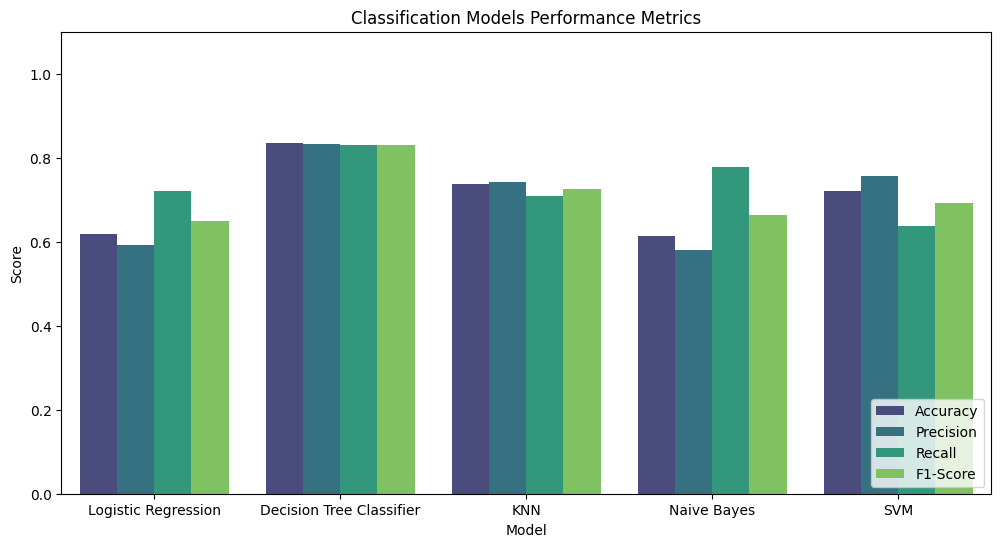

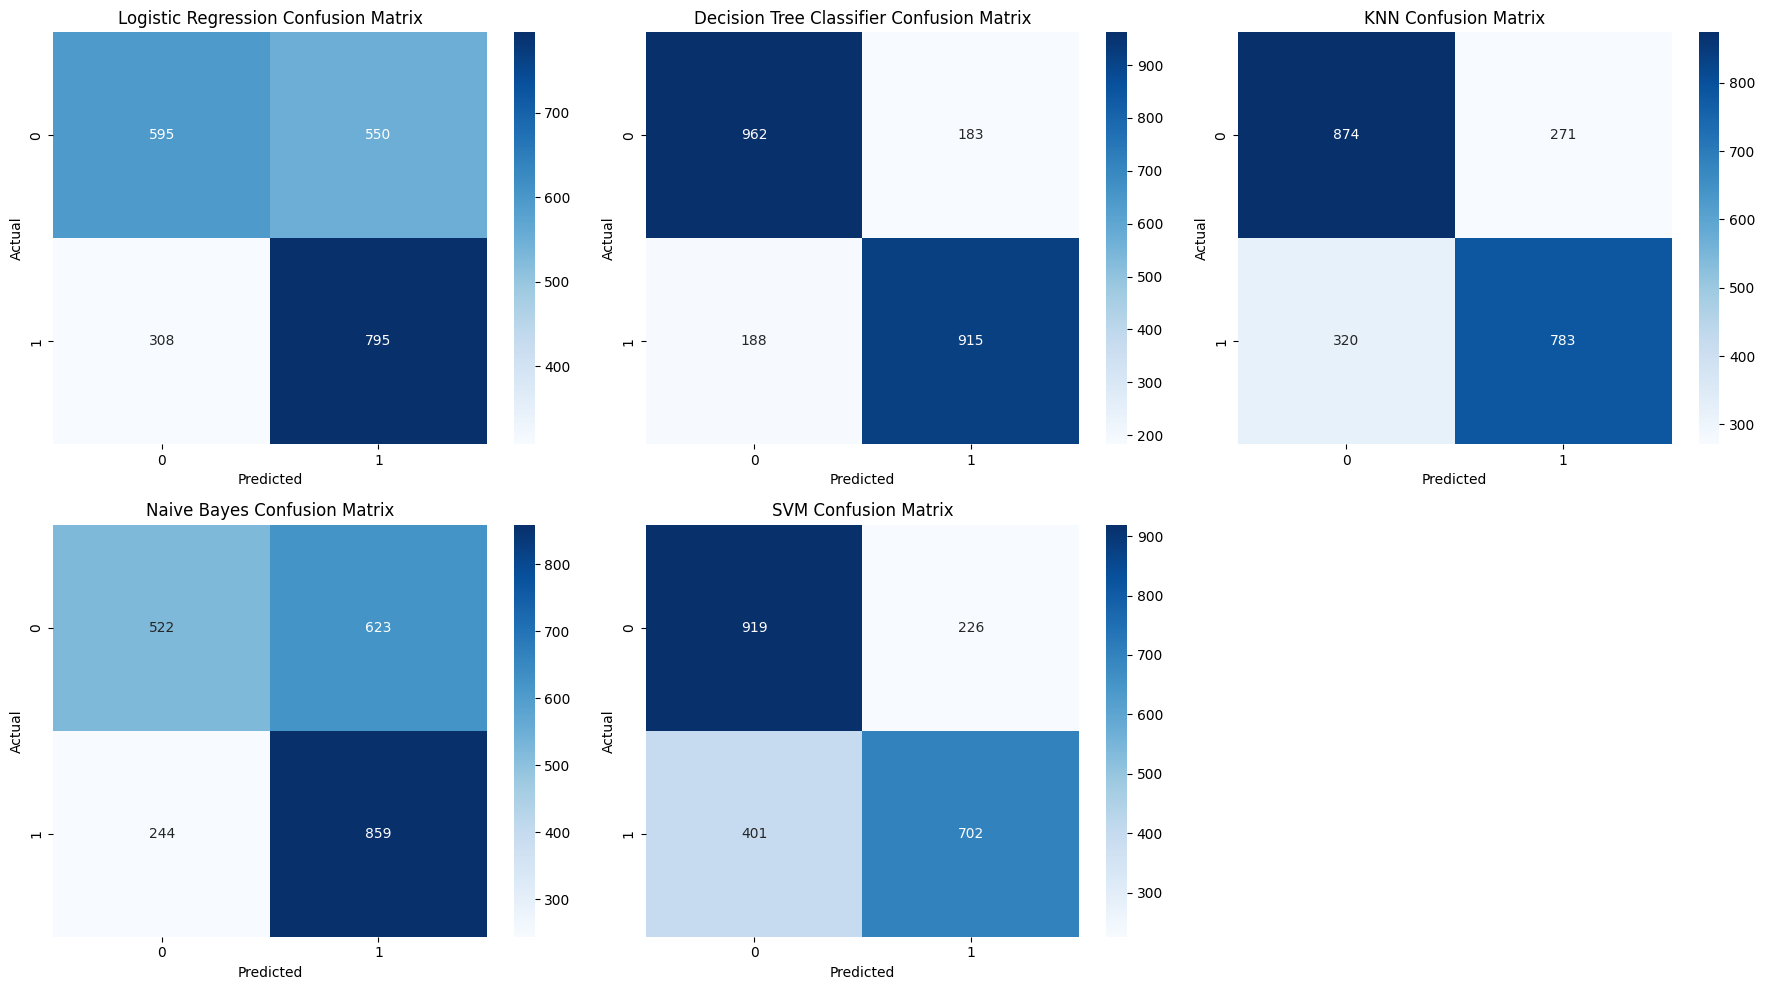

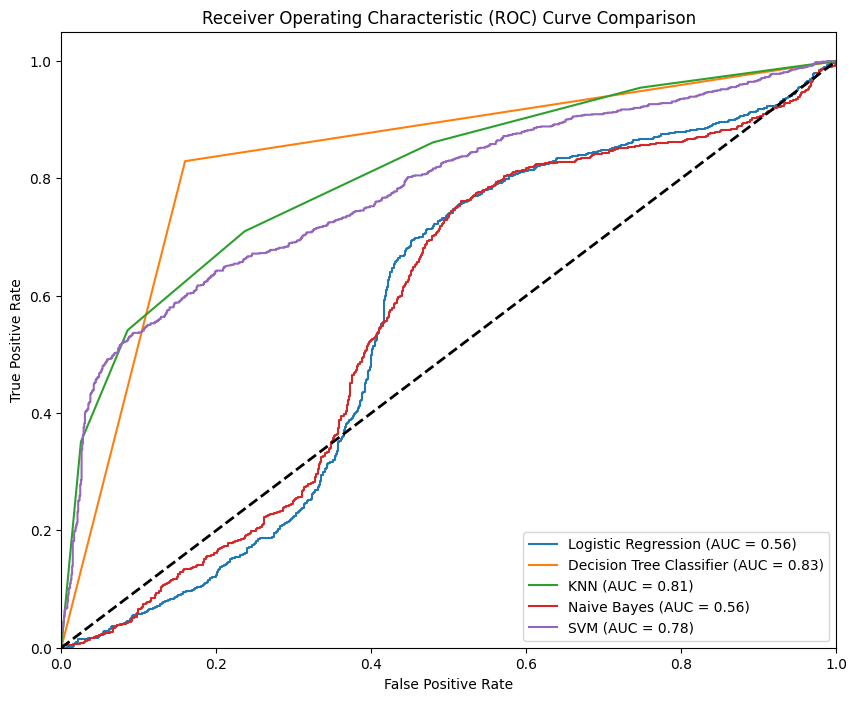

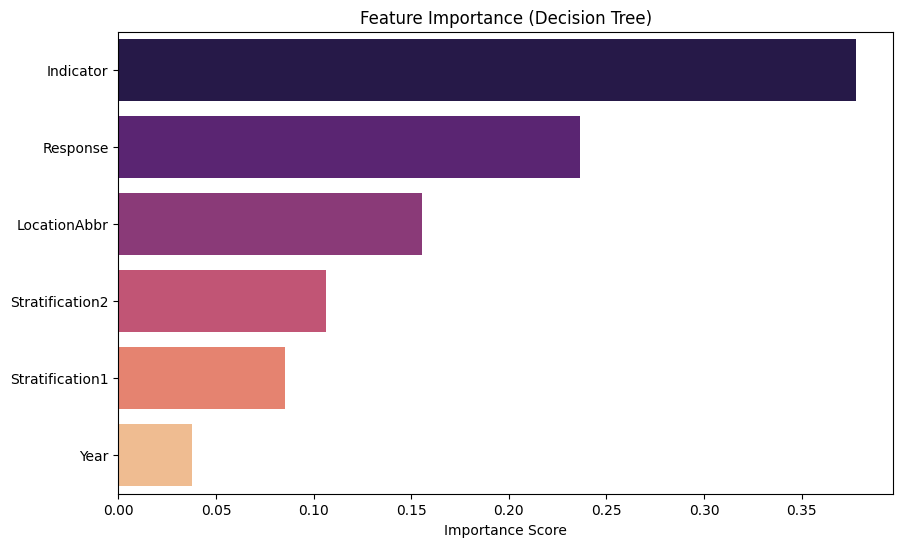

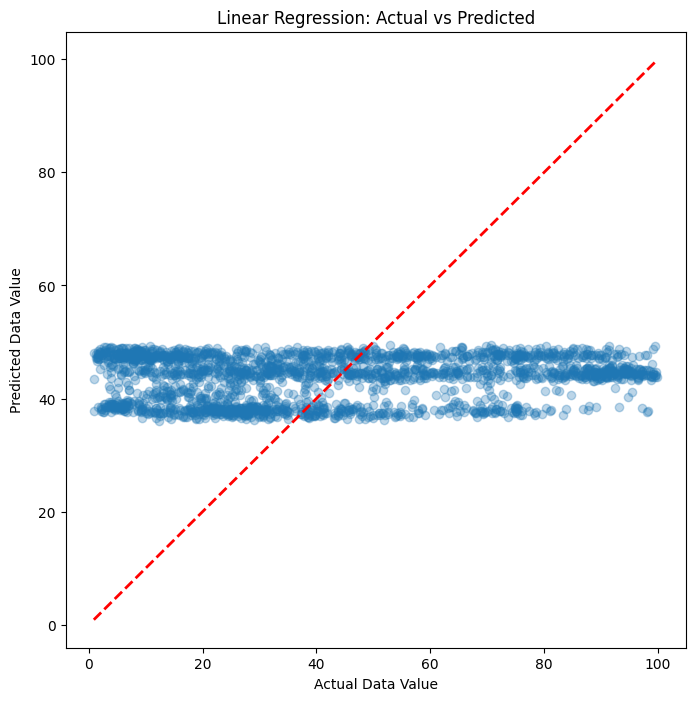

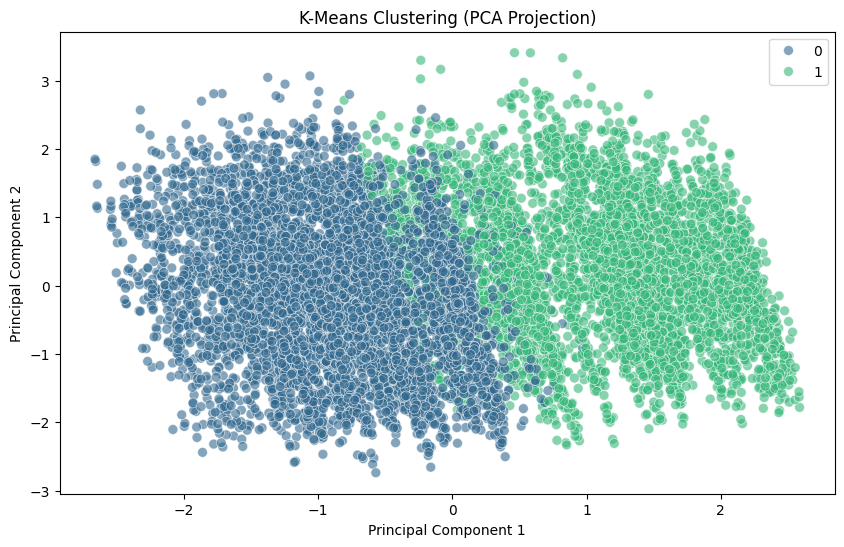

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score, mean_absolute_error

# 1. Load Data
df = pd.read_csv("DHDS_cleaned.csv")

# 2. Preprocessing
# Target for Classification: High (1) vs Low (0) prevalence based on median
median_val = df['Data_Value'].median()
df['Target_Class'] = (df['Data_Value'] > median_val).astype(int)

# Features
feature_cols = ['Year', 'LocationAbbr', 'Indicator', 'Stratification1', 'Response', 'Stratification2']
X = df[feature_cols].copy()
y_class = df['Target_Class']
y_reg = df['Data_Value']

# Encode Categorical Variables
label_encoders = {}
for col in ['LocationAbbr', 'Indicator', 'Stratification1', 'Response', 'Stratification2']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

# 3. Classification Models with Comprehensive Metrics
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(random_state=42, probability=True) # Enable probability for ROC
}

metrics_results = []
conf_matrices = {}
roc_curves = {}

print("Classification Metrics Table:")
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 65)

for name, model in models.items():
    model.fit(X_train, y_train_class)
    preds = model.predict(X_test)
    
    # Calculate Metrics
    acc = accuracy_score(y_test_class, preds)
    prec = precision_score(y_test_class, preds)
    rec = recall_score(y_test_class, preds)
    f1 = f1_score(y_test_class, preds)
    
    metrics_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"{name:<25} {acc:.4f}     {prec:.4f}     {rec:.4f}     {f1:.4f}")
    
    # Store Confusion Matrix
    conf_matrices[name] = confusion_matrix(y_test_class, preds)
    
    # Store ROC Curve Data
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_class, probs)
        roc_auc = auc(fpr, tpr)
        roc_curves[name] = (fpr, tpr, roc_auc)

# 4. Regression Evaluation
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
reg_preds = lin_reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, reg_preds)
mae = mean_absolute_error(y_test_reg, reg_preds)
r2 = r2_score(y_test_reg, reg_preds)

print("\nLinear Regression Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# 5. K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- VISUALIZATIONS ---

# 1. Classification Metrics Comparison Bar Chart
metrics_df = pd.DataFrame(metrics_results)
metrics_df_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Classification Models Performance Metrics")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show()

# 2. Confusion Matrices Heatmaps
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide the last empty subplot if odd number of models
if len(models) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

# 3. ROC Curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# 4. Feature Importance (Decision Tree)
dt_model = models['Decision Tree Classifier']
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(feature_cols)[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names, hue=feature_names, palette='magma', legend=False)
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance Score')
plt.show()

# 5. Linear Regression: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_reg, reg_preds, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Data Value')
plt.ylabel('Predicted Data Value')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

# 6. K-Means PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', alpha=0.6, s=50)
plt.title('K-Means Clustering (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()